# -- START --

In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


import warnings


warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [16, 3]

### read_dataset()

In [216]:
def read_dataset(folder, file, date_col=None):
    '''
    folder: is a Path object
    file: the CSV filename in that Path object. 
    date_col: specify a date_col to use as index_col 
    
    returns: a pandas DataFrame with a DatetimeIndex
    '''
    df = pd.read_csv(folder / file, 
                     index_col=date_col, 
                     parse_dates=[date_col])
    return df

### Create DataFrames 

In [220]:
folder = Path("../../datasets/Ch8")

machine_temp_file = "machine_temp_failure.csv"
nyc_taxi_file = "nyc_taxi.csv"

index_col = 'timestamp'

In [221]:
nyc_taxi = read_dataset(folder, nyc_taxi_file, index_col)
machine_temp = read_dataset(folder, machine_temp_file, index_col)
# traffic = read_dataset(folder, traffic_file, index_col)

### Visualize DataFrames

* **nyc_taxi.csv**: Number of NYC taxi passengers, where the five anomalies occur during the NYC marathon, Thanksgiving, Christmas, New Years day, and a snow storm. The raw data is from the NYC Taxi and Limousine Commission. The data file included here consists of aggregating the total number of taxi passengers into 30 minute buckets.
* **machine_temperature_system_failure.csv**: Temperature sensor data of an internal component of a large, industrial mahcine. The first anomaly is a planned shutdown of the machine. The second anomaly is difficult to detect and directly led to the third anomaly, a catastrophic failure of the machine.
* **Real time traffic data** from the Twin Cities Metro area in Minnesota, collected by the Minnesota Department of Transportation. Included metrics include occupancy, speed, and travel time from specific sensors.

In [222]:
nyc_taxi.index

DatetimeIndex(['2014-07-01 00:00:00', '2014-07-01 00:30:00',
               '2014-07-01 01:00:00', '2014-07-01 01:30:00',
               '2014-07-01 02:00:00', '2014-07-01 02:30:00',
               '2014-07-01 03:00:00', '2014-07-01 03:30:00',
               '2014-07-01 04:00:00', '2014-07-01 04:30:00',
               ...
               '2015-01-31 19:00:00', '2015-01-31 19:30:00',
               '2015-01-31 20:00:00', '2015-01-31 20:30:00',
               '2015-01-31 21:00:00', '2015-01-31 21:30:00',
               '2015-01-31 22:00:00', '2015-01-31 22:30:00',
               '2015-01-31 23:00:00', '2015-01-31 23:30:00'],
              dtype='datetime64[ns]', name='timestamp', length=10320, freq=None)

In [224]:
machine_temp.index

DatetimeIndex(['2013-12-02 21:15:00', '2013-12-02 21:20:00',
               '2013-12-02 21:25:00', '2013-12-02 21:30:00',
               '2013-12-02 21:35:00', '2013-12-02 21:40:00',
               '2013-12-02 21:45:00', '2013-12-02 21:50:00',
               '2013-12-02 21:55:00', '2013-12-02 22:00:00',
               ...
               '2014-02-19 14:40:00', '2014-02-19 14:45:00',
               '2014-02-19 14:50:00', '2014-02-19 14:55:00',
               '2014-02-19 15:00:00', '2014-02-19 15:05:00',
               '2014-02-19 15:10:00', '2014-02-19 15:15:00',
               '2014-02-19 15:20:00', '2014-02-19 15:25:00'],
              dtype='datetime64[ns]', name='timestamp', length=22695, freq=None)

In [226]:
nyc_dates = ['11-02-2014', '11-27-2014', '11-28-2014', 
             '12-24-2014', '12-25-2014', '12-31-2014', 
             '01-01-2015', '01-26-2015', '01-27-2015']

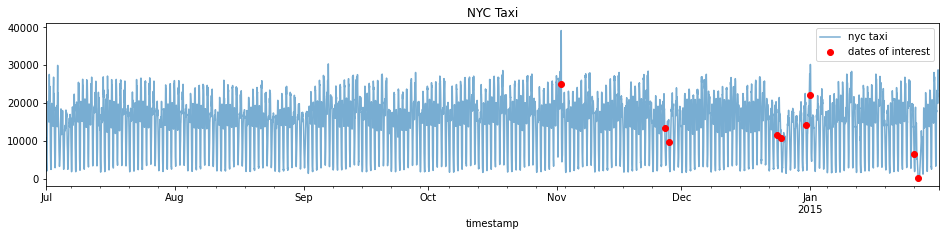

In [227]:
ax = nyc_taxi.plot(title="NYC Taxi", alpha=0.6)
nyc_taxi.loc[nyc_dates].plot(style='ro', ax=ax)
plt.legend(['nyc taxi', 'dates of interest'])

# traffic.plot(title="Traffic Data: Speed")

<AxesSubplot:title={'center':'Machine Temperature Sensor Data'}, xlabel='timestamp'>

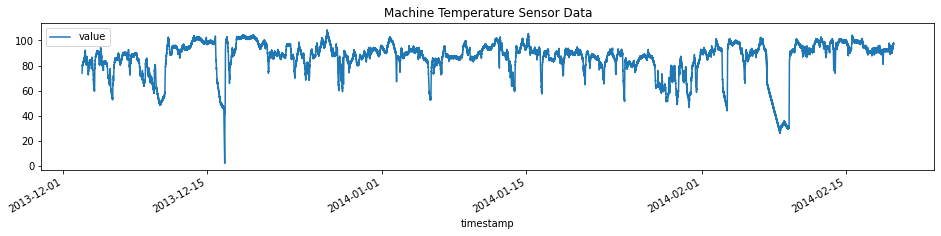

In [228]:
machine_temp.plot(title="Machine Temperature Sensor Data")

<AxesSubplot:xlabel='timestamp'>

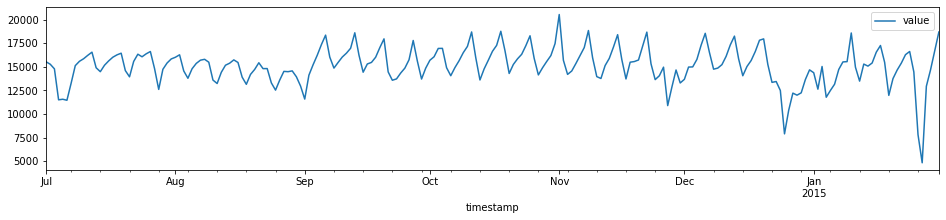

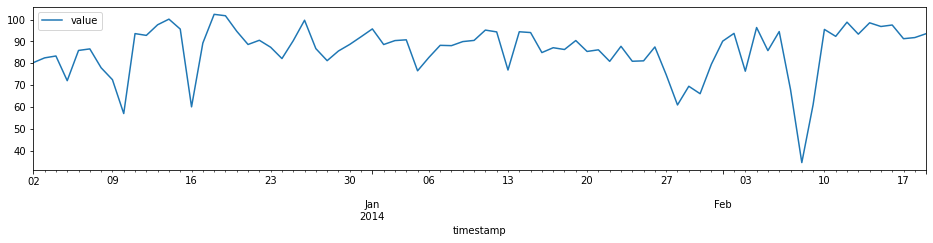

In [229]:
nyc_taxi.resample('D').mean().plot()
machine_temp.resample('D').mean().plot()

# Resampling Time Series Data

In [230]:
nyc_taxi.head()

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820


In [231]:
df_downsampled = nyc_taxi.resample('D').mean()
df_downsampled.head()

,value
timestamp,
2014-07-01,15540.979167
2014-07-02,15284.166667
2014-07-03,14794.625000
2014-07-04,11511.770833
2014-07-05,11572.291667


In [232]:
df_downsampled.index[0]

Timestamp('2014-07-01 00:00:00', freq='D')

In [233]:
df_downsampled.index.freq

<Day>

In [234]:
df_downsampled.shape

(215, 1)

In [235]:
df_downsampled = machine_temp.resample('3D').sum()
df_downsampled.head()

,value
timestamp,
2013-12-02,50382.133560
2013-12-05,70382.125169
2013-12-08,59704.334577
2013-12-11,81755.895600
2013-12-14,73672.877837


In [236]:
df_downsampled.shape

(27, 1)

In [237]:
df_downsampled.index.freq

<3 * Days>

In [238]:
df_downsampled = machine_temp.resample('3B', origin='end_day').sum()
df_downsampled.head(10)

,value
timestamp,
2013-12-02,2648.780734
2013-12-05,68467.848665
2013-12-10,109351.963907
2013-12-13,81755.895600
2013-12-18,128852.422076
2013-12-23,133261.059602
2013-12-26,78367.111514
2013-12-31,125032.813642
2014-01-03,79084.584271


In [239]:
nyc_taxi.resample('15T').mean().head()

,value
timestamp,
2014-07-01 00:00:00,10844.0
2014-07-01 00:15:00,NaN
2014-07-01 00:30:00,8127.0
2014-07-01 00:45:00,NaN
2014-07-01 01:00:00,6210.0


In [240]:
nyc_taxi.resample('15T').fillna('ffill').head()

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:15:00,10844
2014-07-01 00:30:00,8127
2014-07-01 00:45:00,8127
2014-07-01 01:00:00,6210


In [241]:
nyc_taxi.resample('15T').ffill().head()

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:15:00,10844
2014-07-01 00:30:00,8127
2014-07-01 00:45:00,8127
2014-07-01 01:00:00,6210


## There is more

In [242]:
nyc_taxi.resample('MS').agg(['mean', 'min', 
                            'max', 'median', 'sum'])

value                                
                    mean   min    max   median       sum
timestamp                                               
2014-07-01  14994.084677  1769  29985  16625.5  22311198
2014-08-01  14580.438844  1841  26062  16184.0  21695693
2014-09-01  15623.374306  1431  30373  17244.5  22497659
2014-10-01  16086.851478  1691  28626  17767.5  23937235
2014-11-01  15492.125000  1683  39197  17287.0  22308660
2014-12-01  14813.428763  1459  27804  16587.0  22042382
2015-01-01  14399.790995     8  30236  16061.0  21426889

# Detecting Outliers using Statistical Methods

### Histograms

In [243]:
mt = machine_temp.resample('D').mean()
tx = nyc_taxi.resample('D').mean()

In [244]:
percentiles = [0.05, .10, .25, .5, .75, .90, .95]
stats = pd.concat([mt.describe(percentiles=percentiles),
                   tx.describe(percentiles=percentiles)], axis=1)
stats.columns = ['machine_temp', 'nyc_traffic']
stats

,machine_temp,nyc_traffic
count,80.000000,215.000000
mean,85.896254,15137.569380
std,11.536228,1937.391020
min,34.498251,4834.541667
5%,61.017770,11998.181250
10%,71.739424,13043.854167
25%,81.139651,14205.197917
50%,88.362524,15299.937500
75%,93.574618,16209.427083
90%,96.872704,17279.300000


### Box Plots

<AxesSubplot:>

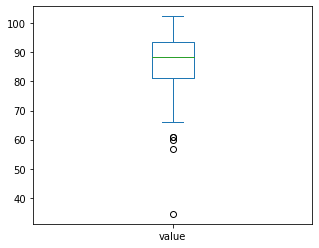

In [245]:
mt.plot.box(figsize=(5, 4))

<AxesSubplot:>

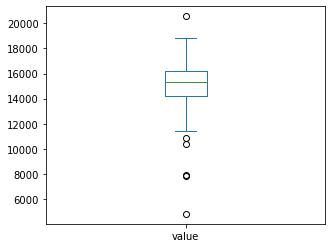

In [246]:
tx.plot.box(figsize=(5,4))

### IQR 

In [247]:
def iqr(data):
    q1, q3 = np.percentile(data, [25, 75])
    IQR = q3 - q1
    lower_fence = q1 - (1.5* IQR)
    upper_fence = q3 + (1.5 * IQR)
    return (lower_fence, upper_fence, IQR)

In [248]:
def iqr_outliers(data):
    iqr_results = iqr(data)
    print(iqr_results)
    return data[(data.value > iqr_results[1]) | (data.value < iqr_results[0])]

In [249]:
iqr_outliers(mt)

(62.487201198576386, 112.22706821635417, 12.434966754444446)


,value
timestamp,
2013-12-10,56.949492
2013-12-16,60.019514
2014-01-28,60.892656
2014-02-08,34.498251
2014-02-09,61.024355


(62.487201198576386, 112.22706821635417, 12.434966754444446)


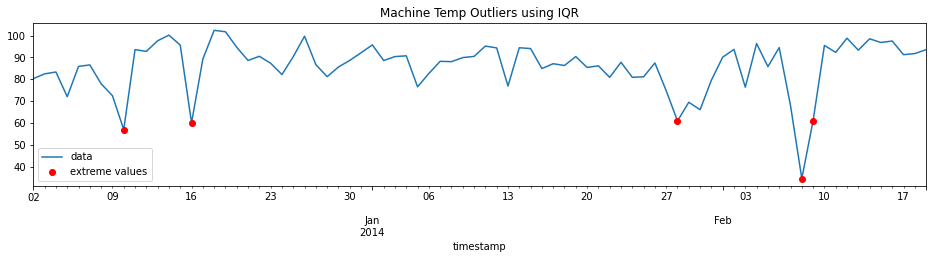

In [250]:
ax = mt.plot()
iqr_outliers(mt).plot(style='or', ax=ax, 
                                title='Machine Temp Outliers using IQR')
plt.legend(['data', 'extreme values'])

In [251]:
iqr_outliers(tx)

(11198.854166666672, 19215.77083333333, 2004.2291666666642)


,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


(11198.854166666672, 19215.77083333333, 2004.2291666666642)


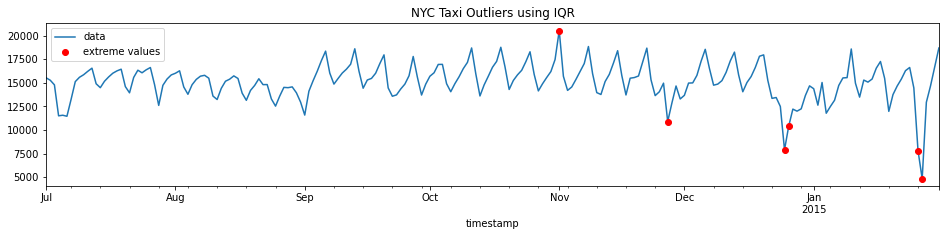

In [252]:
ax = tx.plot()
iqr_outliers(tx).plot(style='or', ax=ax, 
                            title="NYC Taxi Outliers using IQR")
plt.legend(['data', 'extreme values'])

Z-Scores

$$
\Large z = \frac{x - \mu}{\sigma}
$$

In [253]:
def zscore(df):
    data = df.copy()
    data['zscore'] = (data - data.mean())/data.std()
    
    return data[(data['zscore'] > 3) | (data['zscore'] < -3)]['value']

In [255]:
zscore(tx)

timestamp
2014-12-25    7902.125000
2015-01-26    7818.979167
2015-01-27    4834.541667
Name: value, dtype: float64

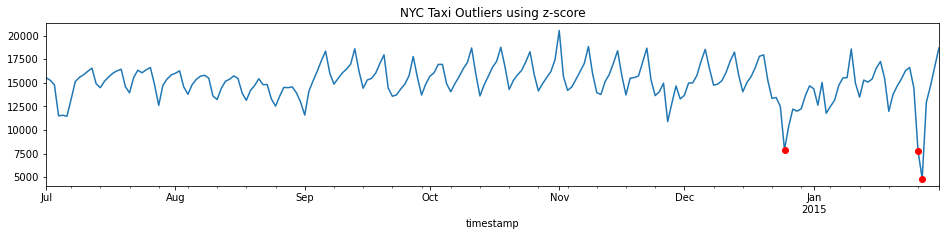

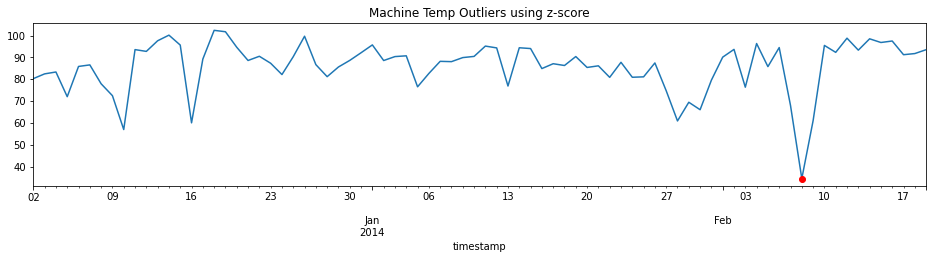

In [256]:
ax = tx['value'].plot()
zscore(tx).plot(style='or', ax=ax, 
                      title="NYC Taxi Outliers using z-score")
plt.show()
ax = mt['value'].plot()
zscore(mt).plot(style='or', ax=ax, 
                          title="Machine Temp Outliers using z-score")
plt.show()

### There is more

In [257]:
from statsmodels.stats.diagnostic import kstest_normal

def test_normal(df):
    t_test, p_value = kstest_normal(df)
    if p_value < 0.05:
        print("Reject null hypothesis. Data is not normal")
    else:
        print("Fail to reject null hypothesis. Data is normal")

In [258]:
test_normal(tx)
test_normal(mt)

Reject null hypothesis. Data is not normal
Reject null hypothesis. Data is not normal


# Detecting Outliers using K-Nearest Neighbors

In [259]:
from pyod.models.knn import KNN

In [260]:
nyc_daily = nyc_taxi.resample('D').mean()

In [261]:
knn = KNN(contamination=0.05,
          method='mean',
          n_neighbors=5)

In [262]:
knn.fit(nyc_daily)

KNN(algorithm='auto', contamination=0.05, leaf_size=30, method='mean',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [263]:
predicted = pd.Series(knn.predict(nyc_daily), 
                      index=nyc_daily.index)

In [264]:
predicted

timestamp
2014-07-01    0
2014-07-02    0
2014-07-03    0
2014-07-04    0
2014-07-05    0
             ..
2015-01-27    1
2015-01-28    0
2015-01-29    0
2015-01-30    0
2015-01-31    0
Freq: D, Length: 215, dtype: int64

In [265]:
print('Number of outliers = ', predicted.sum())

Number of outliers =  6


In [266]:
nyc_daily.loc[nyc_dates]

,value
timestamp,
2014-11-02,15702.187500
2014-11-27,10899.666667
2014-11-28,12850.854167
2014-12-24,12502.000000
2014-12-25,7902.125000
2014-12-31,14686.270833
2015-01-01,14383.479167
2015-01-26,7818.979167
2015-01-27,4834.541667


In [267]:
outliers = predicted[predicted == 1]
outliers = nyc_daily.loc[outliers.index] 
outliers

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


## There is more

In [268]:
def plot_outliers(outliers, data, method='KNN',
                 halignment = 'right', 
                 valignment = 'bottom',
                 labels=False):
    
    min_range = outliers.index.min()
    max_range = outliers.index.max()
    ax = data.loc[min_range:max_range].plot(linewidth=3)
    
    if labels:
        for i in outliers['value'].items():
            plt.plot(i[0], i[1], 'ro')
            plt.text(i[0], i[1], f'{i[0].date()}', 
                         horizontalalignment=halignment,
                         verticalalignment=valignment)
    else:
        plt.legend(['original data','downsampled (H)','Outliers'])
        data.loc[outliers.index].plot(ax=ax, style='rD')
        
    plt.title(f'NYC Taxi Outlier data points using {method}')
    plt.xlabel('date'); plt.ylabel('# of passengers')
    plt.show()

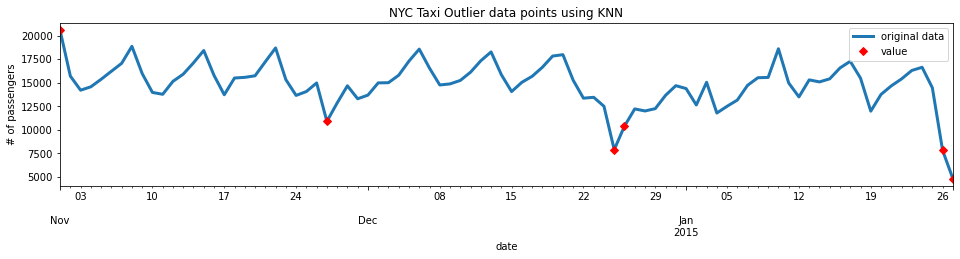

In [269]:
plot_outliers(outliers, nyc_daily, 'KNN')

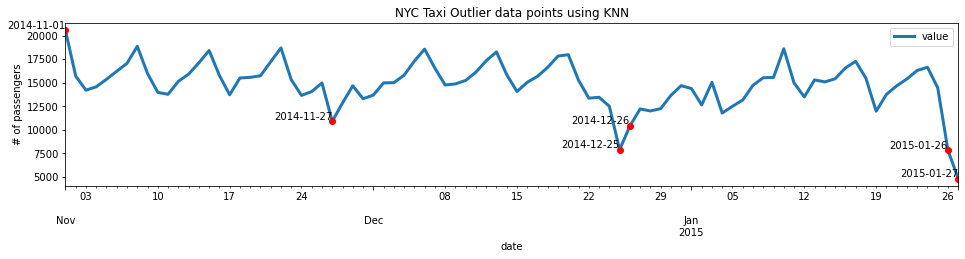

In [270]:
plot_outliers(outliers, 
              nyc_daily, 
              'KNN',
              labels=True)

# Detecting Outliers using Isolation Forests

In [271]:
from pyod.models.iforest import IForest

In [272]:
nyc_daily = nyc_taxi.resample('D').mean()

In [273]:
iforest = IForest(contamination=0.05,
                 n_estimators=100,
                 random_state=0)
iforest.fit(nyc_daily)

IForest(behaviour='old', bootstrap=False, contamination=0.05,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=0, verbose=0)

In [274]:
predicted = pd.Series(iforest.predict(nyc_daily), 
                      index=nyc_daily.index)

In [275]:
print('Number of outliers = ', predicted.sum())

Number of outliers =  11


In [276]:
outliers = predicted[predicted == 1]
outliers = nyc_daily.loc[outliers.index] 
outliers

,value
timestamp,
2014-07-06,11464.270833
2014-10-18,18778.958333
2014-11-01,20553.500000
2014-11-08,18857.333333
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2014-12-29,12250.479167
2015-01-04,11785.604167


## There is more

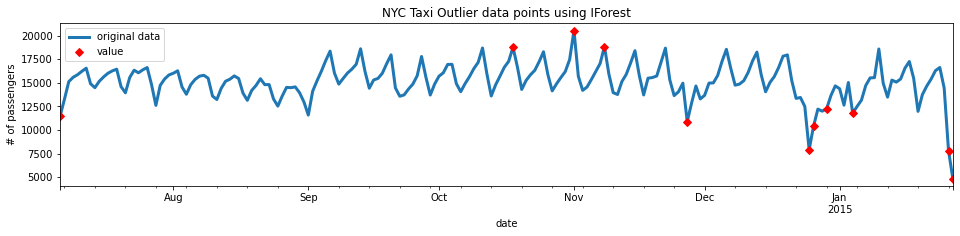

In [277]:
plot_outliers(outliers, nyc_daily, 'IForest')

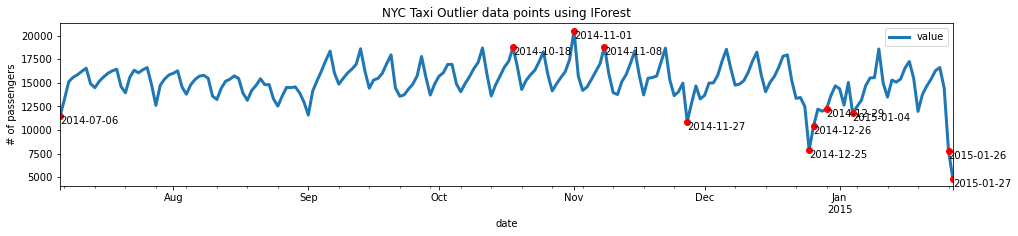

In [278]:
plot_outliers(outliers, 
              nyc_daily, 
              'IForest',
              labels=True,
              halignment='left', 
              valignment='top')

In [279]:
nyc_taxi.loc['2014-07-04':'2014-07-07'].resample('D').min()

,value
timestamp,
2014-07-04,3276
2014-07-05,2514
2014-07-06,2510
2014-07-07,1877


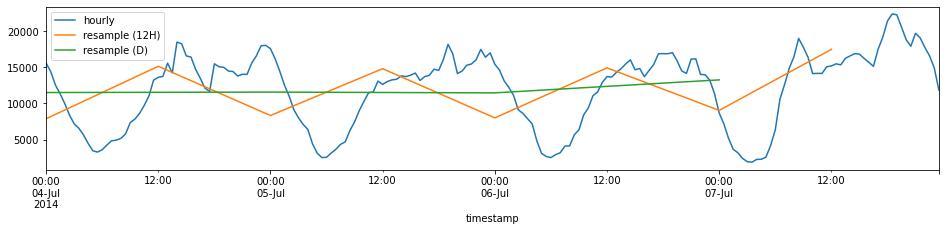

In [280]:
interest = nyc_taxi.loc['2014-07-04':'2014-07-07']
ax = interest.plot()
interest.resample('12H').mean().plot(ax=ax)
interest.resample('D').mean().plot(ax=ax)
plt.legend(['hourly','resample (12H)','resample (D)'])

# Detecing Outliers using Copula-Based Outlier Detection (COPOD)

In [281]:
from pyod.models.copod import COPOD

In [282]:
nyc_daily = nyc_taxi.resample('D').mean()

copod = COPOD(contamination=0.05)
copod.fit(nyc_daily)

COPOD(contamination=0.05, n_jobs=1)

In [283]:
predicted = pd.Series(copod.predict(nyc_daily), 
                      index=nyc_daily.index)

In [284]:
print('Number of outliers = ', predicted.sum())

Number of outliers =  11


In [285]:
outliers = predicted[predicted == 1]
outliers = nyc_daily.loc[outliers.index] 
outliers

,value
timestamp,
2014-07-04,11511.770833
2014-07-05,11572.291667
2014-07-06,11464.270833
2014-09-01,11589.875000
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-04,11785.604167
2015-01-19,11982.854167


## There is more

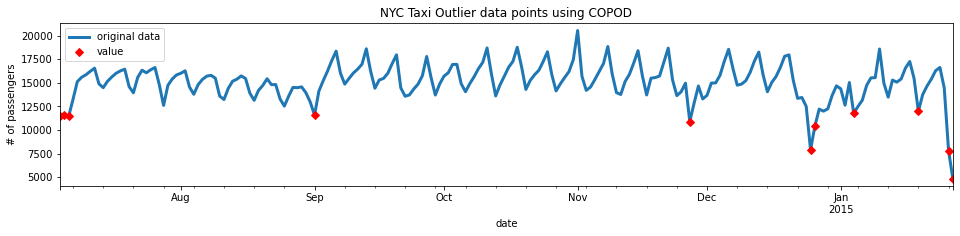

In [286]:
plot_outliers(outliers, nyc_daily, 'COPOD')

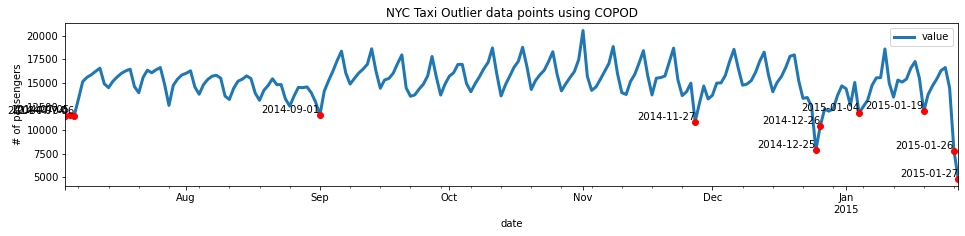

In [287]:
plot_outliers(outliers, 
              nyc_daily, 
              'COPOD',
              labels=True,
              halignment='right', 
              valignment='bottom')